Preamble

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from astropy.table import Table

Plotting functions

In [2]:
def scatter_hist(ax, x, y, xlim=None, ylim=None, log_norm=True, cmap='gray',
                 cmin=10, vmin=None, vmax=None, nbins=50, color='k'):
    """
    Generate a scatter plot and overlayed 2D histogram for dense data.

    Parameters
    ----------
    ax : matplotlib.axis.Axes
        Axes object on which to plot the data.
    x : array-like
        Horizontal coordinates of the data points.
    y : array-like
        Vertical coordinates of the data points.
    xlim : float, optional
        Bounds for x-axis. The default is None.
    ylim : float, optional
        Bounds for y-axis. The default is None.
    log_norm : bool, optional
        Shade the 2D histogram on a logarithmic scale. The default is True.
    cmap : str, optional
        Colormap for 2D histogram. The default is'gray'.
    cmin : int, optional
        Minimum counts per bin; any number below this will show individual points.
        The default is 10.
    vmin : float or None, optional
        Value to map to minimum of histogram normalization. The default is None.
    vmax : float or None, optional
        Value to map to maximum of histogram normalization. The default is None.
    nbins : int or tuple of ints, optional
        Number of histogram bins. If a tuple, presumed to be (xbins, ybins).
        The default is 50.
    color : str, optional
        Color of individual points. The default is 'k'.

    Returns
    -------
    matplotlib.axis.Axes

    """
    # Set automatic plot bounds
    if not xlim:
        xlim = (np.min(x), np.max(x))
    if not ylim:
        ylim = (np.min(y), np.max(y))
    # Set bin edges
    if type(nbins) == 'tuple':
        xbins, ybins = nbins
    else:
        xbins = ybins = nbins
    xbins = np.linspace(xlim[0], xlim[1], num=xbins, endpoint=True)
    ybins = np.linspace(ylim[0], ylim[1], num=ybins, endpoint=True)
    # Histogram normalization
    if log_norm:
        norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        
    ax.scatter(x, y, c=color, s=0.5)
    ax.hist2d(x, y, bins=[xbins, ybins], cmap=cmap, norm=norm, cmin=cmin)
        
    dx = xbins[1] - xbins[0]
    dy = ybins[1] - ybins[0]
    ax.set_xlim((xlim[0] - 2*dx, xlim[1] + 2*dx))
    ax.set_ylim((ylim[0] - 2*dy, ylim[1] + 2*dy))
    
    return ax

Import ASPCAP allStar file and make some preliminary quality cuts.
Also remove any entries without a 2MASS ID (a very small percentage).

In [3]:
aspcap_path = Path("data/allStarLite-dr17-synspec.fits")
# Import APOGEE allStar data
aspcap_table = Table.read(aspcap_path, format='fits', hdu=1)
# Separate paramflags into individual columns
for i in range(len(aspcap_table['PARAMFLAG'][0])):
    aspcap_table['PARAMFLAG' + str(i)] = aspcap_table['PARAMFLAG'][:,i]
# Filter out multidimensional columns
cols = [name for name in aspcap_table.colnames if len(aspcap_table[name].shape) <= 1]

def decode(df):
    """
    Decode DataFrame with byte strings into ordinary strings.
    """
    str_df = df.select_dtypes([object])
    str_df = str_df.stack().str.decode('utf-8').unstack()
    for col in str_df:
        df[col] = str_df[col]
    return df

aspcap_df = decode(aspcap_table[cols].to_pandas())
# Replace NaN stand-in values with NaN
aspcap_df.replace(99.999, np.nan, inplace=True)
# Replace NaN in ASPCAPFLAGS with empty string
aspcap_df["ASPCAPFLAGS"].replace(np.nan, "", inplace=True)
# Replace '' with 'none' in columns of type 'object'
# aspcap_df.replace('', 'none', inplace=True)
# Remove VESTA
aspcap_df.drop(0, inplace=True)
# Weed out bad flags
fatal_flags = (2**23) # STAR_BAD
aspcap_df = aspcap_df[aspcap_df["ASPCAPFLAG"] & fatal_flags == 0]
aspcap_df.reset_index(inplace=True, drop=True)
# Copy 2Mass ID column without "2M" prefix
# also limit to targets with a 2Mass ID
aspcap_df = aspcap_df[aspcap_df["APOGEE_ID"].str.contains("2M")]
aspcap_df["TMASS_ID"] = [id[2:] for id in aspcap_df.APOGEE_ID.tolist()]
aspcap_df["TMASS_ID"].to_csv("data/apogee_tmass_ids.csv", index=False, header=False)

aspcap_df

,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,PARAMFLAG0,PARAMFLAG1,PARAMFLAG2,PARAMFLAG3,PARAMFLAG4,PARAMFLAG5,PARAMFLAG6,PARAMFLAG7,PARAMFLAG8,TMASS_ID
0,2M00000002+7417074,apo25m,120+12,none,0.000103,74.285408,119.401807,11.767414,8.597,0.039,...,0,33554432,0,0,0,0,0,0,0,00000002+7417074
1,2M00000019-1924498,apo25m,060-75,none,0.000832,-19.413851,63.394122,-75.906397,11.074,0.022,...,0,0,288,0,0,256,0,0,0,00000019-1924498
2,2M00000032+5737103,apo25m,116-04,none,0.001335,57.619530,116.065371,-4.564768,10.905,0.023,...,0,0,0,0,0,32,0,0,0,00000032+5737103
3,2M00000032+5737103,apo25m,N7789,none,0.001335,57.619530,116.065371,-4.564768,10.905,0.023,...,0,0,0,0,0,32,0,0,0,00000032+5737103
4,2M00000035-7323394,lco25m,SMC12,none,0.001467,-73.394287,307.939441,-43.230305,15.008,0.045,...,32,33554464,32,32,32,32,32,0,0,00000035-7323394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691629,2M23595867-7339039,lco25m,SMC12,none,359.994493,-73.651093,307.846602,-42.982597,15.671,0.069,...,0,33554464,0,0,32,32,32,0,0,23595867-7339039
691630,2M23595886+5726058,apo25m,116-04,none,359.995265,57.434956,116.025359,-4.745011,11.466,0.024,...,0,16777216,0,0,0,0,0,0,0,23595886+5726058
691631,2M23595921+5609479,apo25m,NGC7789_MGA,none,359.996744,56.163330,115.771964,-5.991363,11.985,0.023,...,0,33554432,0,0,0,0,0,0,0,23595921+5609479
691632,2M23595949-7342592,lco25m,SMC12,none,359.997887,-73.716454,307.821174,-42.919934,15.924,0.094,...,0,33554464,0,0,32,32,32,0,0,23595949-7342592


Import GALAH

In [210]:
galah_path = Path("data/GALAH_DR3_main_allstar_v2.fits")
galah_table = Table.read(galah_path, format="fits")
galah_df = decode(galah_table.to_pandas())
galah_df = galah_df[(galah_df["snr_c3_iraf"] > 30) &
                    (galah_df["flag_sp"] == 0) &
                    (galah_df["flag_fe_h"] == 0)]
# TODO also limit to flag_X_fe for any elemental abundance X
galah_df

,star_id,sobject_id,dr2_source_id,dr3_source_id,survey_name,field_id,flag_repeat,wg4_field,wg4_pipeline,flag_sp,...,ks_m,ks_msigcom,ph_qual_tmass,w2mpro,w2mpro_error,ph_qual_wise,a_ks,e_a_ks,bc_ks,ruwe_dr2
0,03325271-6840304,131116000501002,4667368899326730240,4667368899326730240,galah_main,138,0,10k_2,lbol,0,...,10.607,0.021,AAA,10.558,0.019,AAAU,0.082620,0.026685,2.198110,1.098764
8,03405609-6844483,131116000501012,4667320108498311168,4667320108498311168,galah_main,138,0,10k_44,lbol,0,...,11.926,0.023,AAA,11.939,0.021,AABC,0.010098,0.028591,1.549377,1.027320
9,03403587-6844432,131116000501013,4667320795693075456,4667320795693075456,galah_main,138,0,10k_20,lbol,0,...,11.405,0.026,AAA,11.424,0.020,AAAU,0.011934,0.027980,1.958494,1.189190
11,03402113-6848514,131116000501015,4667319455663284224,4667319455663284224,galah_main,138,0,10k_49,lbol,0,...,12.340,0.029,AAA,12.316,0.021,AABU,0.000000,0.031400,1.455364,1.001337
12,03394376-6848101,131116000501018,4667319043346417664,4667319043346417664,galah_main,138,0,10k_15,lbol,0,...,11.239,0.021,AAA,11.235,0.020,AAAU,0.015606,0.030113,2.103191,1.075210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588566,15142072-4415325,190225005301395,6003344796319529984,6003344796319529984,galah_main,4235,0,190225,lbol,0,...,6.438,0.020,AAA,6.453,0.025,AAAA,0.080784,0.046457,2.122558,0.841033
588567,15151322-4415182,190225005301396,6000435312445129728,6000435312445129728,galah_main,4235,0,190225,lbol,0,...,10.139,0.021,AAA,10.102,0.020,AAAU,0.024786,0.026622,1.232041,0.915573
588568,15162269-4414571,190225005301397,6000421607212226560,6000421607212226560,galah_main,4235,0,190225,lbol,0,...,7.364,0.026,AAA,7.309,0.020,AAAB,0.155142,0.044369,2.401451,1.114932
588569,15161847-4418028,190225005301398,6000420675196587008,6000420675196587008,galah_main,4235,0,190225,lbol,0,...,8.810,0.019,AAA,8.841,0.020,BAAB,0.045900,0.041054,1.967848,0.926810


Import astrophysical parameters from Gaia DR3.

In [7]:
gaia_params = pd.read_csv("data/gaia_astrophysical_parameters.csv", 
                          dtype={"classlabel_espels": "object"})
gaia_params.set_index("original_ext_source_id", inplace=True)
gaia_params.drop_duplicates(inplace=True)
gaia_params

,source_id,ra,dec,solution_id,source_id.1,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,classprob_dsc_combmod_whitedwarf,classprob_dsc_combmod_binarystar,...,ag_msc_upper,ag_msc_lower,logposterior_msc,mcmcaccept_msc,mcmcdrift_msc,flags_msc,neuron_oa_id,neuron_oa_dist,neuron_oa_dist_percentile_rank,flags_oa
original_ext_source_id,,,,,,,,,,,,,,,,,,,,,
00000002+7417074,538028216707715712,0.000205,74.285436,1636148068921376768,538028216707715712,1.029028e-13,5.139943e-13,0.999913,2.019855e-12,0.000087,...,0.669155,0.635234,-605880.80000,0.304487,1.211973,1.0,NaN,NaN,NaN,NaN
00000019-1924498,2413929812587459072,0.000970,-19.413922,1636148068921376768,2413929812587459072,1.047278e-13,5.231100e-13,0.999732,1.868176e-09,0.000268,...,0.204702,0.126441,394.37555,0.294726,0.033347,0.0,NaN,NaN,NaN,NaN
00000032+5737103,422596679964513792,0.001332,57.619507,1636148068921376768,422596679964513792,1.022279e-13,5.106234e-13,0.999980,1.723692e-10,0.000020,...,0.928979,0.475252,-1288.87620,0.140406,0.099076,1.0,NaN,NaN,NaN,NaN
00000035-7323394,4689447878791422208,0.001481,-73.394323,1636148068921376768,4689447878791422208,1.020988e-13,5.523579e-13,0.999994,5.982815e-10,0.000006,...,0.768308,0.000000,102.58035,0.230191,0.071842,0.0,NaN,NaN,NaN,NaN
00000068+5710233,421077597267551104,0.002913,57.173075,1636148068921376768,421077597267551104,1.023049e-13,5.110079e-13,0.999972,2.008120e-12,0.000028,...,0.919130,0.353034,-21008.60700,0.147947,0.047836,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23595886-2009435,2341765776376373376,359.995295,-20.162166,1636148068921376768,2341765776376373376,1.029946e-13,5.144531e-13,0.999904,2.021658e-12,0.000096,...,0.439015,0.000000,603.45550,0.144057,0.031283,0.0,NaN,NaN,NaN,NaN
23595886+5726058,1998097371124974720,359.995268,57.434918,1636148068921376768,1998097371124974720,1.020373e-13,5.096712e-13,0.999999,2.002867e-12,0.000001,...,0.439536,0.420394,-29813.63300,0.299332,0.678233,1.0,NaN,NaN,NaN,NaN
23595921+5609479,1994741318040223232,359.996716,56.163345,1636148068921376768,1994741318040223232,1.020473e-13,5.097213e-13,0.999998,2.003064e-12,0.000002,...,2.164036,0.091880,-16314.74500,0.240167,0.105819,1.0,NaN,NaN,NaN,NaN


In [8]:
alldata = aspcap_df.copy()
alldata.set_index("TMASS_ID", inplace=True,drop=True)
alldata = alldata.join(gaia_params, how="inner")
alldata

,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,ag_msc_upper,ag_msc_lower,logposterior_msc,mcmcaccept_msc,mcmcdrift_msc,flags_msc,neuron_oa_id,neuron_oa_dist,neuron_oa_dist_percentile_rank,flags_oa
00000002+7417074,2M00000002+7417074,apo25m,120+12,none,0.000103,74.285408,119.401807,11.767414,8.597,0.039,...,0.669155,0.635234,-605880.80000,0.304487,1.211973,1.0,NaN,NaN,NaN,NaN
00000019-1924498,2M00000019-1924498,apo25m,060-75,none,0.000832,-19.413851,63.394122,-75.906397,11.074,0.022,...,0.204702,0.126441,394.37555,0.294726,0.033347,0.0,NaN,NaN,NaN,NaN
00000032+5737103,2M00000032+5737103,apo25m,116-04,none,0.001335,57.619530,116.065371,-4.564768,10.905,0.023,...,0.928979,0.475252,-1288.87620,0.140406,0.099076,1.0,NaN,NaN,NaN,NaN
00000032+5737103,2M00000032+5737103,apo25m,N7789,none,0.001335,57.619530,116.065371,-4.564768,10.905,0.023,...,0.928979,0.475252,-1288.87620,0.140406,0.099076,1.0,NaN,NaN,NaN,NaN
00000035-7323394,2M00000035-7323394,lco25m,SMC12,none,0.001467,-73.394287,307.939441,-43.230305,15.008,0.045,...,0.768308,0.000000,102.58035,0.230191,0.071842,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23595867-7339039,2M23595867-7339039,lco25m,SMC12,none,359.994493,-73.651093,307.846602,-42.982597,15.671,0.069,...,0.409695,0.000000,151.24228,0.262053,0.098688,0.0,NaN,NaN,NaN,NaN
23595886+5726058,2M23595886+5726058,apo25m,116-04,none,359.995265,57.434956,116.025359,-4.745011,11.466,0.024,...,0.439536,0.420394,-29813.63300,0.299332,0.678233,1.0,NaN,NaN,NaN,NaN
23595921+5609479,2M23595921+5609479,apo25m,NGC7789_MGA,none,359.996744,56.163330,115.771964,-5.991363,11.985,0.023,...,2.164036,0.091880,-16314.74500,0.240167,0.105819,1.0,NaN,NaN,NaN,NaN
23595949-7342592,2M23595949-7342592,lco25m,SMC12,none,359.997887,-73.716454,307.821174,-42.919934,15.924,0.094,...,0.663985,0.000000,149.14719,0.238687,0.012151,0.0,NaN,NaN,NaN,NaN


In [9]:
rg = alldata[(alldata["TEFF"] < 6000) & (alldata["LOGG"] < 4)]

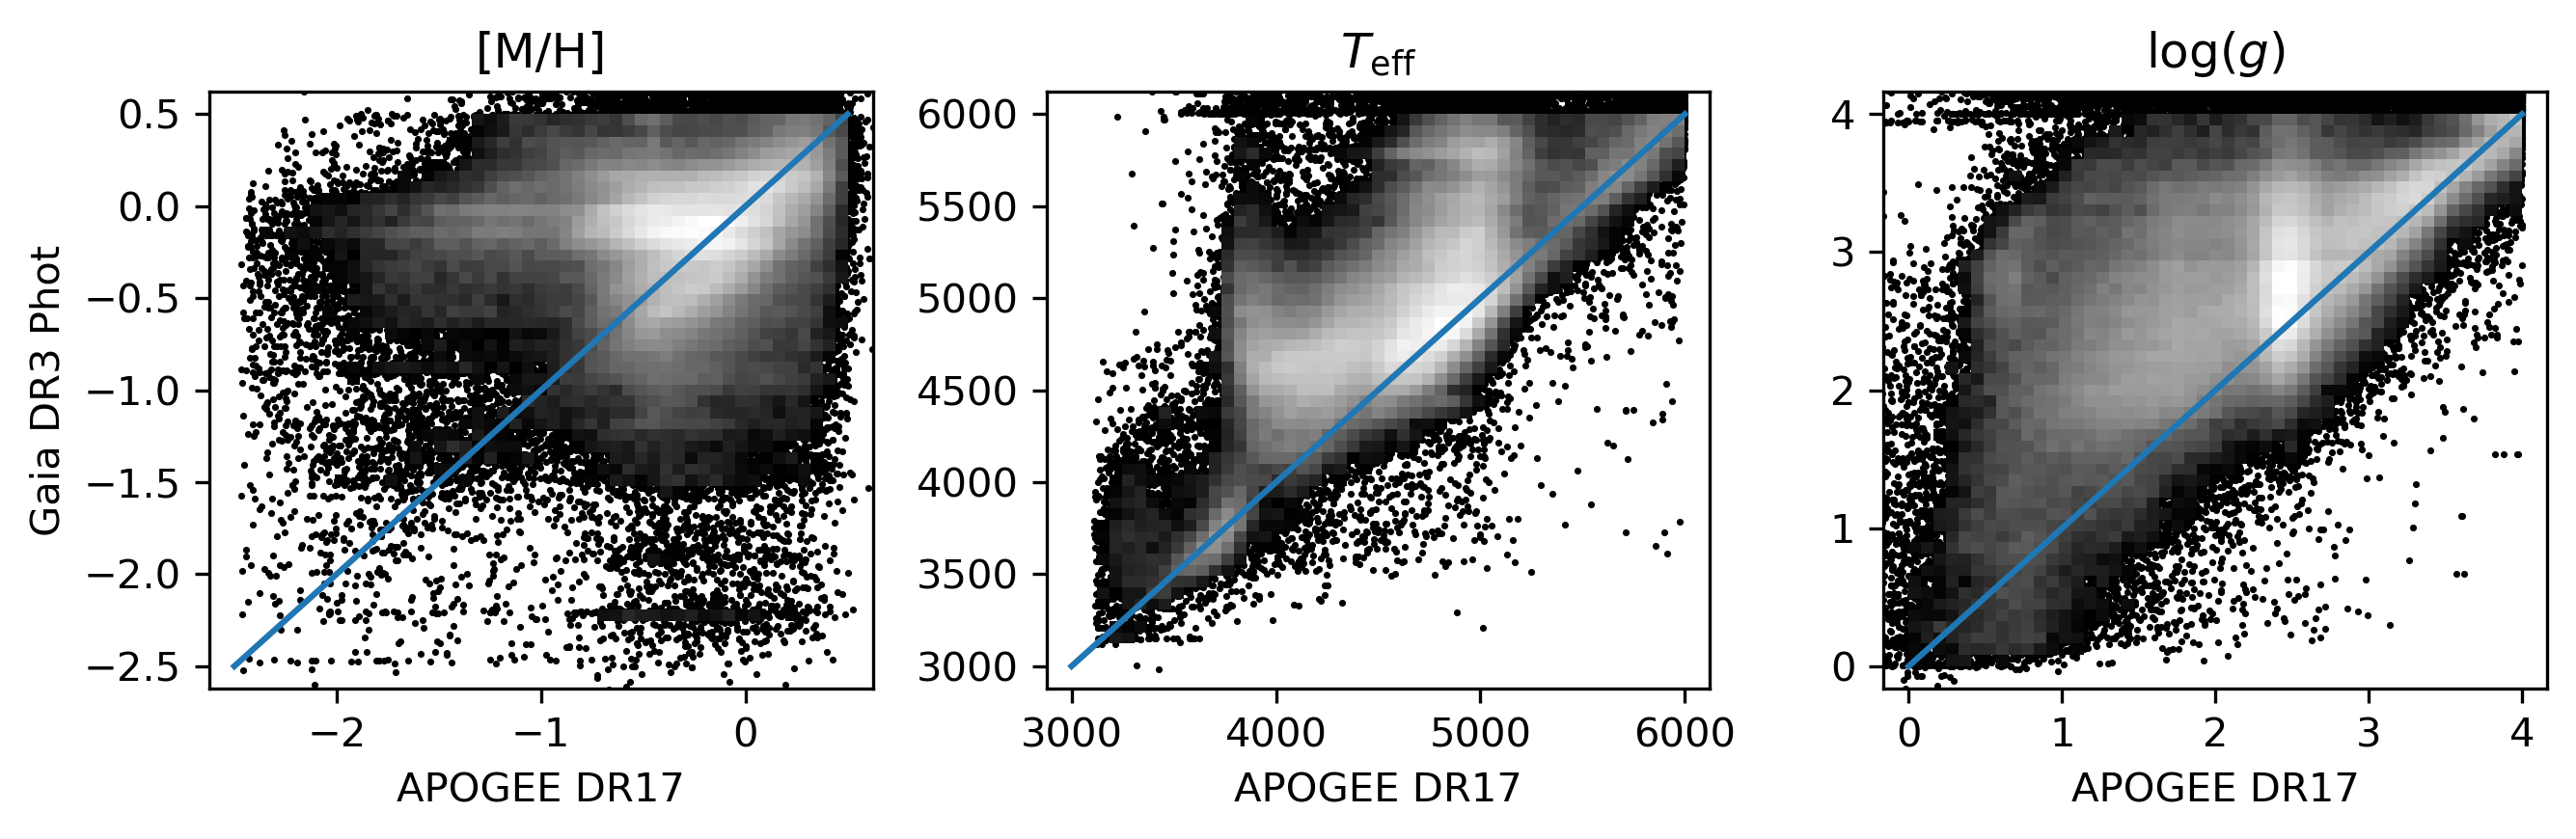

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), dpi=300, tight_layout=True)
scatter_hist(axs[0], rg["M_H"], rg["mh_gspphot"], xlim=(-2.5, 0.5), ylim=(-2.5, 0.5))
# axs[0].scatter(rg["M_H"], rg["mh_gspphot"], s=0.1, c='k')
axs[0].plot([-2.5, 0.5], [-2.5, 0.5])
axs[0].set_xlabel("APOGEE DR17")
axs[0].set_ylabel("Gaia DR3 Phot")
axs[0].set_title("[M/H]")
scatter_hist(axs[1], rg["TEFF"], rg["teff_gspphot"], xlim=(3000, 6000), ylim=(3000, 6000))
# axs[1].scatter(rg["TEFF"], rg["teff_gspphot"], s=0.1, c=rg["M_H"])
axs[1].plot([3000, 6000], [3000, 6000])
# axs[1].set_ylim((2900, 6100))
axs[1].set_xlabel("APOGEE DR17")
axs[1].set_title(r"$T_{\rm{eff}}$")
scatter_hist(axs[2], rg["LOGG"], rg["logg_gspphot"], xlim=(0, 4), ylim=(0, 4))
# axs[2].scatter(rg["LOGG"], rg["logg_gspphot"], s=0.1, c=rg["M_H"])
axs[2].plot([0, 4], [0, 4])
# axs[2].set_ylim((-1, 5))
axs[2].set_xlabel("APOGEE DR17")
axs[2].set_title(r"$\log(g)$")
plt.show()

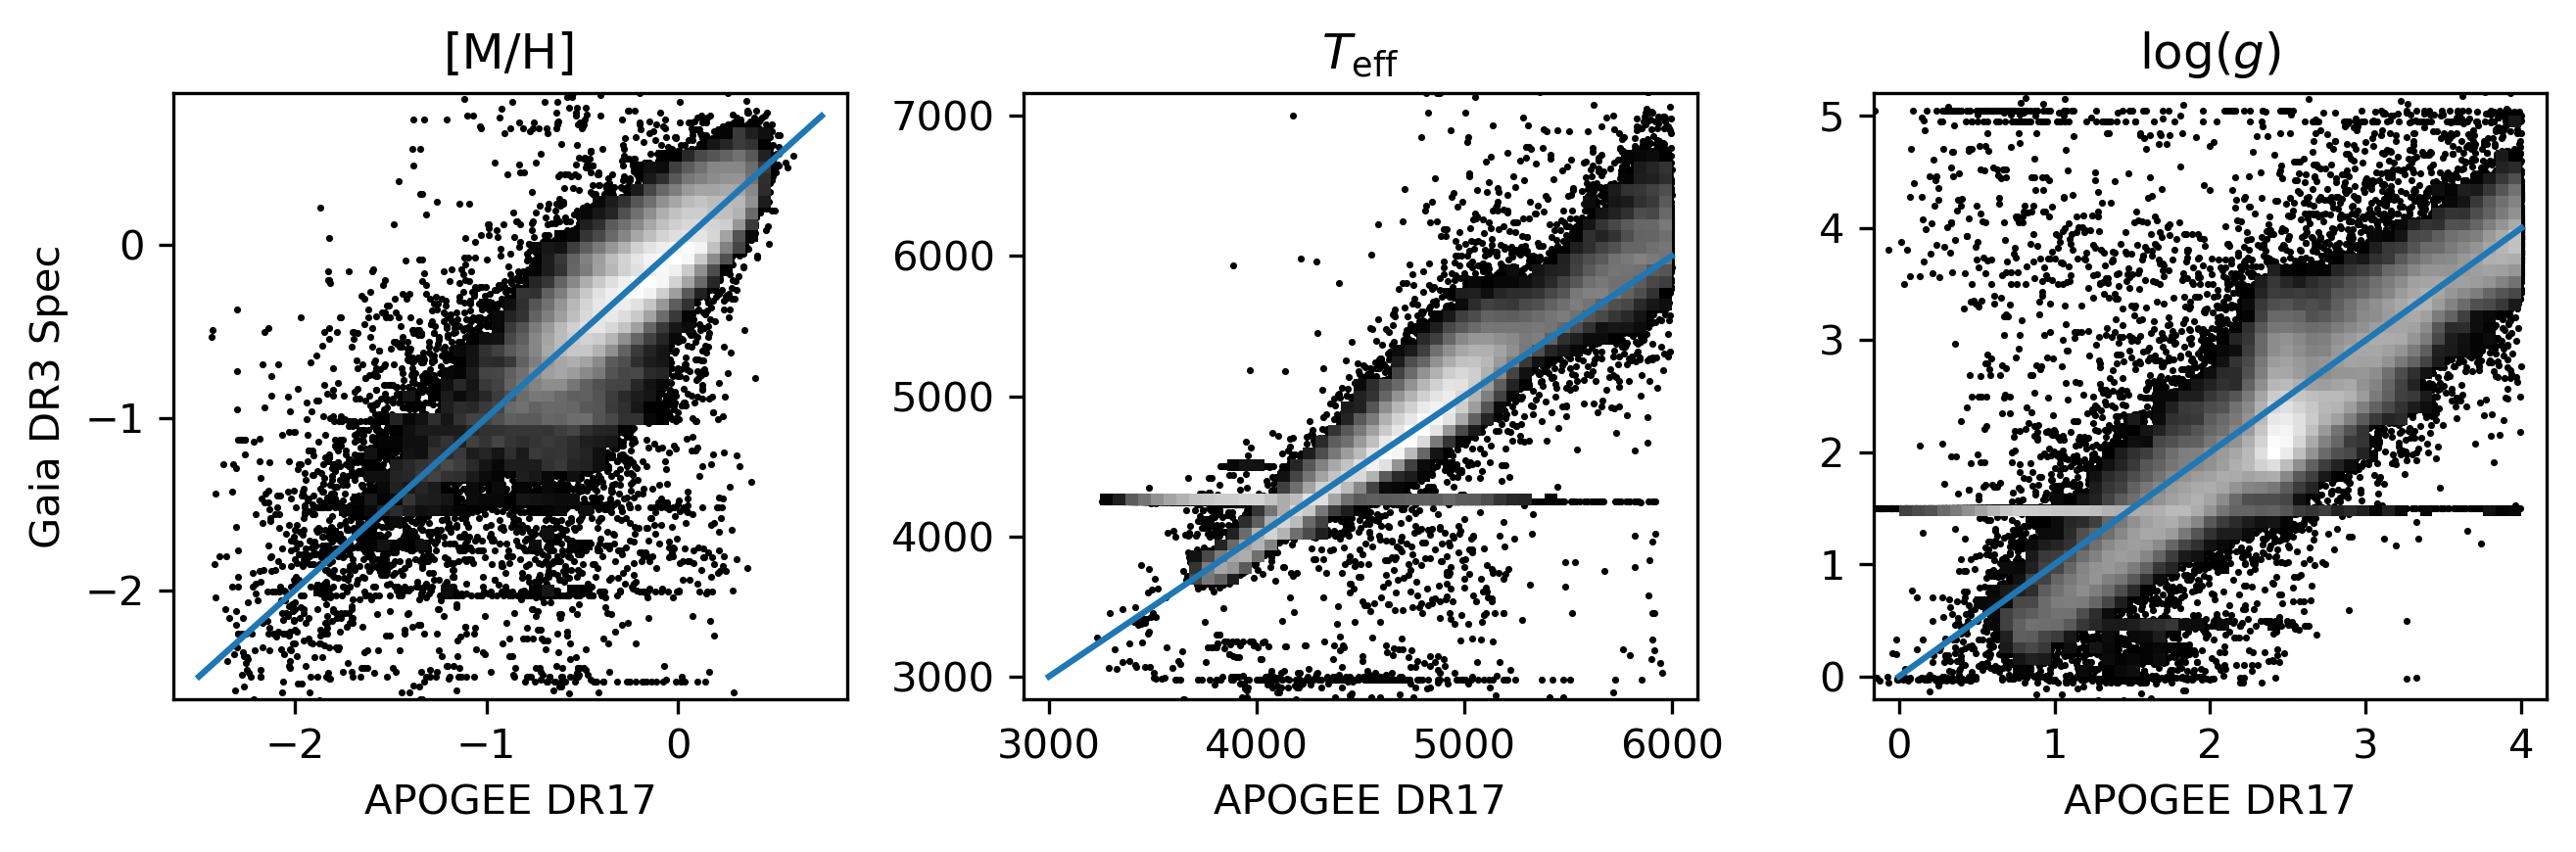

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), dpi=300, tight_layout=True)
scatter_hist(axs[0], rg["M_H"], rg["mh_gspspec"], xlim=(-2.5, 0.75), ylim=(-2.5, 0.75))
# axs[0].scatter(rg["M_H"], rg["mh_gspphot"], s=0.1, c='k')
axs[0].plot([-2.5, 0.75], [-2.5, 0.75])
axs[0].set_xlabel("APOGEE DR17")
axs[0].set_ylabel("Gaia DR3 Spec")
axs[0].set_title("[M/H]")
scatter_hist(axs[1], rg["TEFF"], rg["teff_gspspec"], xlim=(3000, 6000), ylim=(3000, 7000))
# axs[1].scatter(rg["TEFF"], rg["teff_gspphot"], s=0.1, c=rg["M_H"])
axs[1].plot([3000, 6000], [3000, 6000])
# axs[1].set_ylim((2900, 6100))
axs[1].set_xlabel("APOGEE DR17")
axs[1].set_title(r"$T_{\rm{eff}}$")
scatter_hist(axs[2], rg["LOGG"], rg["logg_gspspec"], xlim=(0, 4), ylim=(0, 5))
# axs[2].scatter(rg["LOGG"], rg["logg_gspphot"], s=0.1, c=rg["M_H"])
axs[2].plot([0, 4], [0, 4])
# axs[2].set_ylim((-1, 5))
axs[2].set_xlabel("APOGEE DR17")
axs[2].set_title(r"$\log(g)$")
plt.show()